In [1]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]

import scipy.io as io
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space
from scipy.linalg import sqrtm

import jax
from jax import jit, vmap, random, grad
from jax.experimental import optimizers
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc
import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

In [2]:
import utils
from utils import *

/home/orange3xchicken/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Graph has negative weights: dijkstra will give inaccurate results if the graph contains negative cycles. Consider johnson or bellman_ford.
  


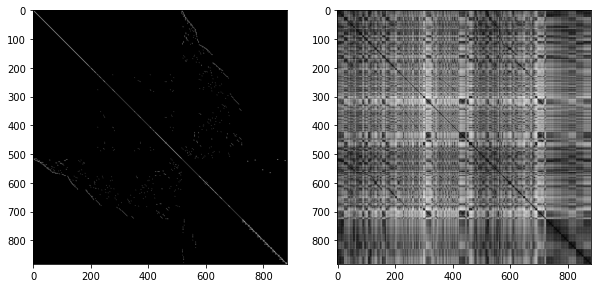

In [3]:
# load the data from the SuiteSparse Matrix Collection format
#   https://www.cise.ufl.edu/research/sparse/matrices/
graph_name = 'qh882'
mat_data = io.loadmat(graph_name + '.mat')
graph = mat_data['Problem']['A'][0][0]
fig1, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,20))
ax1.imshow(graph.todense()!=0, cmap='gray')
graphdist = csgraph.shortest_path(graph, directed=False, unweighted=True)
ax2.imshow(graphdist, cmap='gray')

In [4]:
G = nx.from_numpy_matrix(graph.toarray().astype(int)!= 0, create_using=None)
A = nx.adjacency_matrix(G).toarray()
L = csgraph_laplacian(A, normed=False)
D = np.diag(np.sum(A, axis=1))
n = L.shape[0]

In [5]:
@jit
def f(X, A_x, A_y, b_x, b_y):
    return X[:,0].T@A_x@X[:,0] + X[:,1].T@A_y@X[:,1] + 2*b_x.T@X[:,0] + 2*b_y.T@X[:,1]

def g(X, v, c):
    return np.array([v.T@X[:,0], v.T@X[:,1]]) - c

def h(X, D, c1, c2, c3, c=jnp.array([0,0])):
    return np.array([(X[:,0]-c[0]).T@D@(X[:,0]-c[0]) - c1, 
                     (X[:,1]-c[1]).T@D@(X[:,1]-c[1]) - c2, 
                     2*((X[:,0]-c[0]).T@D@(X[:,1]-c[1]) - c3)])

In [6]:
@jit
def project(X1, C, c=jnp.array([0,0])):
    X1 = X1
    C1 = X1.T@X1
    C1sqrt = utils._sqrtm(C1)
    Csqrt = utils._sqrtm(C)
    U,s,V = jnp.linalg.svd(Csqrt@C1sqrt)
    X = X1@jnp.linalg.inv(C1sqrt)@U@V.T@Csqrt
    
    return X.real

In [7]:
def pgd(X_k, A_x, A_y, b_x, b_y, C, c=jnp.array([0,0])):
    loss = []
    param_hist  = []
    for k in tqdm(range(1000)):
        X_k_x = X_k[:,0] - alpha*A_x@X_k[:,0]
        X_k_y = X_k[:,1] - alpha*A_y@X_k[:,1]
        X_k = np.vstack([X_k_x,X_k_y]).T - alpha*np.vstack([b_x,b_y]).T
        X_k = project(X_k, C, c)
        param_hist.append(X_k)
        loss.append(f(X_k, A_x, A_y, b_x, b_y))   
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist}

@jit
def step(i, opt_state, A_x, A_y, b_x, b_y):
    p = get_params(opt_state)
    g = grad(f)(p, A_x, A_y, b_x, b_y)
    return opt_update(i, g, opt_state)

def pgd_autograd(opt_params, A_x, A_y, b_x, b_y, C, maxiters=1000):
    opt_state, opt_update, get_params = opt_params
    loss = []
    param_hist  = []
    for k in tqdm(range(maxiters)):
        opt_state = step(k, opt_state, A_x, A_y, b_x, b_y)
        X_k = get_params(opt_state)
        param_hist.append(X_k)
        loss.append(np.array(f(X_k, A_x, A_y, b_x, b_y)))
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist}

@jit
def _step(i, opt_state, Z):
    return opt_update(i, Z, opt_state)

@jit
def sqp(A, L, E_0, X):
    I = jnp.eye(A.shape[0])
    w, v = jnp.linalg.eig(L)
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]

    D = jnp.diag(w)
    E = -E_0 - (A@X + X@L)
    
    Del_0 = jnp.linalg.inv(X.T@jnp.linalg.inv(A + D[0,0]*I)@X)@X.T@jnp.linalg.inv(A + D[0,0]*I)@E[:,0]
    Z_0 = jnp.linalg.inv(A + D[0,0]*I)@(-X@Del_0 + E[:,0])
    
    Del_1 = jnp.linalg.inv(X.T@jnp.linalg.inv(A + D[1,1]*I)@X)@X.T@jnp.linalg.inv(A + D[1,1]*I)@E[:,1]
    Z_1 = jnp.linalg.inv(A + D[1,1]*I)@(-X@Del_1 + E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del

def newton(opt_params, A, L, X_k, b_x, b_y, maxiters=100, alpha=-0.5, beta=0.9):
    opt_state, opt_update, get_params = opt_params
    loss = []
    param_hist  = []
    E_0 = np.stack([b_x, b_y], axis=1)
    X_k, L = get_params(opt_state)
    
    
    data = {'L':[], 'gradcorr':[]}
    for k in tqdm(range(maxiters)):  
        Z, Del = sqp(A, L, E_0, X_k)
        
        # backtracking line search
        f_x = f(X_k, A, A, b_x, b_y)
        f_xp = 1e8
        stp = 1
        derphi = np.trace(np.dot(grad(f)(X_k, A, A, b_x, b_y).T, Z)).real

        len_p = np.linalg.norm(Z)
        X_k_t = X_k
        L_t = L
        opt_state_t = opt_state
        
        while f_xp >= f_x - alpha * stp * derphi:
            stp *= beta
            opt_state_t = _step(stp, opt_state, (-Z, -Del))
            X_k_t, L_t = get_params(opt_state_t)
            f_xp = np.array(f(X_k_t, A, A, b_x, b_y))
        
            if stp * len_p < 1e-6:
                break

        X_k = X_k_t
        L = L_t
        opt_state = opt_state_t
        #l = np.array(f(X_k, A, A, b_x, b_y))
        
        param_hist.append(X_k)    
        loss.append(f_xp)
        data['gradcorr'].append(derphi)
        data['L'].append(L_t)
        
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'ext_data':data}
    
def ssm():
    """
    1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    """
    pass

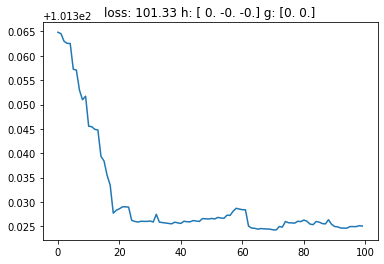

In [8]:
"""SQP test"""
def cluster(rng, opt_params, X_k, A, fixed_indices, maxiters=1000,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8):
    assert len(A.shape) == 2
    assert A.shape[0] == X_k.shape[0]
    
    k = fixed_indices.shape[0]
    fixed_coordsx = X_k[fixed_indices,0]
    fixed_coordsy = X_k[fixed_indices,1]

    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    if D is None:
        D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)

    fixed_idx = np.zeros((k,N))
    for i in range(k):
        fixed_idx[i,fixed_indices[i]] += 1
        
    if k>0:
        """
        need to fix this 2 quadratic forms -> 1 quadratic form
        """
        constraints = np.concatenate([fixed_idx,np.expand_dims(1-fixed_idx.sum(0),0)])
        fixed_coordsx = np.concatenate([fixed_coordsx,np.expand_dims(centercons[0],0)])
        fixed_coordsy = np.concatenate([fixed_coordsy,np.expand_dims(centercons[1],0)])
        P = null_space(constraints).T
        
        n0_x = np.linalg.pinv(constraints)@fixed_coordsx
        #P_x = null_space(constraints).T
        b_x = P@A@n0_x
        
        
        #A_x = P_x@A@P_x.T

        n0_y = np.linalg.pinv(constraints)@fixed_coordsy
        #P_y = null_space(constraints).T
        b_y = P@A@n0_y
        
        
        #A_y = P_y@A@P_y.T
        A = P@A@P.T
    else:
        constraints = np.expand_dims(np.ones(n),0)    
        P = null_space(constraints).T

        n0_x = np.linalg.pinv(constraints)@(np.expand_dims(centercons[0],0))
        b_x = P@A@n0_x

        n0_y = np.linalg.pinv(constraints)@(np.expand_dims(centercons[1],0))
        b_y = P@A@n0_y
         
        A = P@A@P.T
        
    C = jnp.block([[c1, c3],[c3, c2]])

    assert np.linalg.det(C) > 1e-5  
    
    n0 = np.stack([n0_x,n0_y],axis=0)
    X_k_n = np.array(np.linalg.pinv(P.T)@(X_k-n0.T))
    L = np.ones((2,2))
    
    ##########
    #opt_init, opt_update, get_params = padam(1e-1,partial(lambda x, y, z: project(z, x, y), C, centroid), 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))
    opt_init, opt_update, get_params = opt_params
    opt_state = opt_init((X_k_n, L))
    result = newton((opt_state, opt_update, get_params), A, L, X_k_n, b_x, b_y, 
                    maxiters=100, alpha=0.5, beta=0.9)

    ##########
    
    
    X_k = result['x']
    
    X_k_n = np.zeros((N,2))
    X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
    X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
        
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(np.bool)
    result['mask'] = mask
    result['centroid'] = centercons
    if fixed_idx.sum() == 0:
        result['g'] = g(X_k_n, v, centercons)
        result['h'] = h(X_k_n, np.diag(v), c1, c2, c3, centroid)        
    else:
        result['g'] = g(X_k_n[mask], v[mask], centercons)
        result['h'] = h(X_k_n[mask], np.diag(v[mask]), c1, c2, c3, centroid)
    result['P'] = (P)
    result['n'] = (n0_x, n0_y)

    return result

seed = 0
rng = random.PRNGKey(seed)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

#opt_init, opt_update, get_params = padam(5e-1,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)
opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))

eps = 1e-8
alpha = 5e-3
key, subkey = jax.random.split(rng)

#X_k = random.normal(subkey, (n,2))
#X_k = X_k/np.linalg.norm(X_k)*100

w,v = np.linalg.eig(L)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
#X_k = v[:,-3:-1]
X_k = v[:,-2:]

fixed_indices = np.array([],dtype=int)
result = cluster(rng, (opt_init, opt_update, get_params), 
                 X_k, L, fixed_indices,c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8)

X_k_n=result['x']
loss = result['lossh']
param_hist = result['sln_path']

gc = result['g']
hc = result['h']
plt.plot(loss)
plt.title('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))
plt.show()

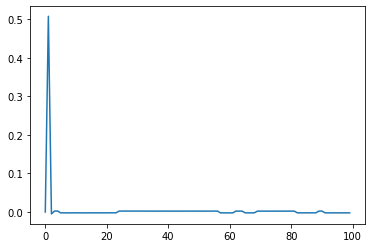

In [9]:
plt.plot(result['ext_data']['gradcorr'])

In [ ]:
def cluster(rng, opt_params, X_k, A, fixed_indices, maxiters=1000,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8):
    assert len(A.shape) == 2
    assert A.shape[0] == X_k.shape[0]
    
    k = fixed_indices.shape[0]
    fixed_coordsx = X_k[fixed_indices,0]
    fixed_coordsy = X_k[fixed_indices,1]

    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    if D is None:
        D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)

    fixed_idx = np.zeros((k,N))
    for i in range(k):
        fixed_idx[i,fixed_indices[i]] += 1
        
    if k>0:
        constraints = np.concatenate([fixed_idx,np.expand_dims(1-fixed_idx.sum(0),0)])
        fixed_coordsx = np.concatenate([fixed_coordsx,np.expand_dims(centercons[0],0)])
        fixed_coordsy = np.concatenate([fixed_coordsy,np.expand_dims(centercons[1],0)])
                
        n0_x = np.linalg.pinv(constraints)@fixed_coordsx
        P_x = null_space(constraints).T
        b_x = P_x@A@n0_x
        A_x = P_x@A@P_x.T

        n0_y = np.linalg.pinv(constraints)@fixed_coordsy
        P_y = null_space(constraints).T
        b_y = P_y@A@n0_y
        A_y = P_y@A@P_y.T
    else:
        n0_x = np.linalg.pinv(np.expand_dims(np.ones(n),0))@(np.expand_dims(centercons[0],0))
        P_x = null_space(np.expand_dims(np.ones(n),0)).T
        b_x = P_x@A@n0_x
        A_x = P_x@A@P_x.T

        n0_y = np.linalg.pinv(np.expand_dims(np.ones(n),0))@(np.expand_dims(centercons[1],0))
        P_y = null_space(np.expand_dims(np.ones(n),0)).T
        b_y = P_y@A@n0_y
        A_y = P_y@A@P_y.T
        k = 1

    C = jnp.block([[c1, c3],[c3, c2]])

    assert np.linalg.det(C) > 1e-5    
    
    X_x = np.array(np.linalg.pinv(P_x.T)@(X_k[:,0]-n0_x.T))
    X_y = np.array(np.linalg.pinv(P_y.T)@(X_k[:,1]-n0_y.T))
    
    X_k_n = np.zeros((X_x.shape[0],2))
    
    X_k_n[:,0] = X_x
    X_k_n[:,1] = X_y

    opt_init, opt_update, get_params = padam(1e-2,partial(lambda x, y, z: project(z, x, y), C, centroid), 
                                             b1=0.9, b2=0.999, eps=1e-08)
    opt_init, opt_update, get_params = opt_params
    opt_state = opt_init(X_k_n)
    result = pgd_autograd((opt_state, opt_update, get_params), A_x, A_y, b_x, b_y, C, maxiters)
    #result = pgd(X_k_n, A_x, A_y, b_x, b_y, C, centroid)
    
    X_k = result['x']

    # take minimum-cost solution along path
    #mincostidx = np.argmin(result['lossh'])
    #X_k = result['sln_path'][mincostidx]
    
    X_k_n = np.zeros((N,2))
    X_k_n[:,0] = np.array(P_x.T@X_k[:,0]) + n0_x.T
    X_k_n[:,1] = np.array(P_y.T@X_k[:,1]) + n0_y.T
        
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(np.bool)
    result['mask'] = mask
    result['centroid'] = centercons
    if fixed_idx.sum() == 0:
        result['g'] = g(X_k_n, v, centercons)
        result['h'] = h(X_k_n, np.diag(v), c1, c2, c3, centroid)        
    else:
        result['g'] = g(X_k_n[mask], v[mask], centercons)
        result['h'] = h(X_k_n[mask], np.diag(v[mask]), c1, c2, c3, centroid)
    result['P'] = (P_x, P_y)
    result['n'] = (n0_x, n0_y)

    return result

seed = 0
rng = random.PRNGKey(seed)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

opt_init, opt_update, get_params = padam(1e-1,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)

eps = 1e-8
alpha = 5e-3
key, subkey = jax.random.split(rng)

X_k = random.normal(subkey, (n,2))
X_k = X_k/np.linalg.norm(X_k)*100
fixed_indices = np.array([],dtype=int)
result = cluster(rng, (opt_init, opt_update, get_params), 
                 X_k, L, fixed_indices,c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), v=None, D=None, eps=1e-8)

X_k_n=result['x']
loss = result['lossh']
param_hist = result['sln_path']

gc = result['g']
hc = result['h']
plt.plot(loss)
plt.title('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))
plt.show()

In [10]:
size = np.array([4, 4])
voxel_id, voxel2bound = voxel_cluster(X_k_n, size)

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Text(0.5, 1.0, 'colored by voxel-cluster')

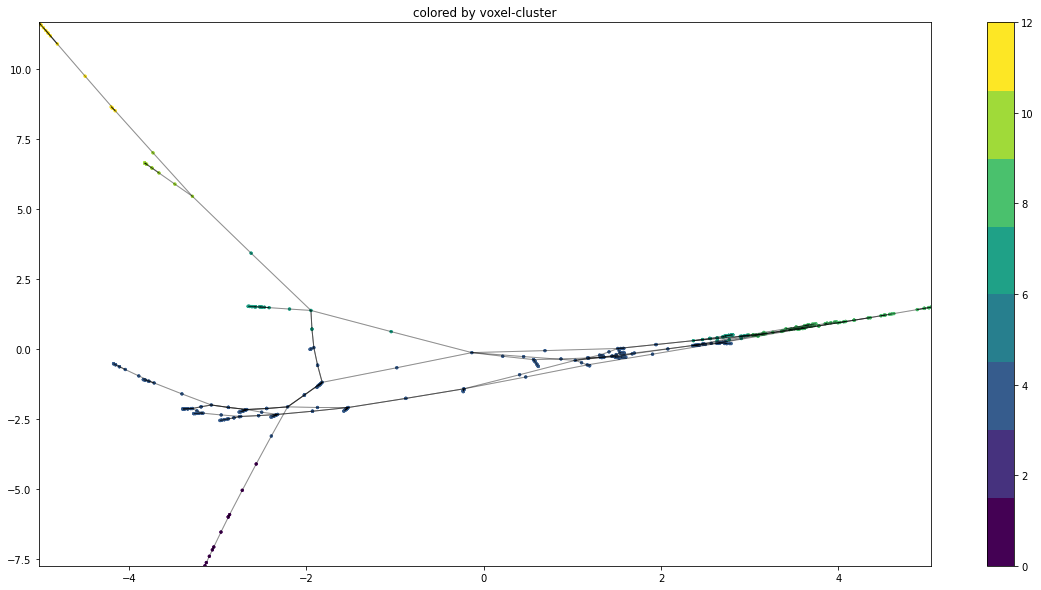

In [11]:
positions = X_k_n

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_xlim(min(positions[:,0]), max(positions[:,0]))
ax.set_ylim(min(positions[:,1]), max(positions[:,1]))

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
ax.add_collection(lc)
cmap = plt.cm.get_cmap('viridis', np.unique(voxel_id).shape[0])    # 11 discrete colors
z = gaussian_kde(positions.T)(positions.T)
scatter = ax.scatter(positions[:,0], positions[:,1], s=5, c=voxel_id, cmap=cmap)

#for c in np.where(cidx)[0]:
#    ax.annotate('({},{})'.format(str(np.round(X_k_n[c, 0],2)), str(np.round(X_k_n[c, 1],2))), (X_k_n[c, 0], X_k_n[c, 1]))

plt.colorbar(scatter, ax=ax)
plt.title('colored by voxel-cluster')
#plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

In [ ]:
"""DFS"""

"""
procedure DFS-iterative(G,v):
      let S be a stack
      S.push(v)
      while S is not empty:
          v = S.pop()
          if v is not labeled as discovered:
              label v as discovered
              for all edges from v to w in G.adjacentEdges(v) :
                  if edge has required value:
                       S.push(w)
"""

def DFS(i, maxdepth, X_k, results):
    if i > maxdepth:
        return results
    size = np.array([10, 10])
    voxel_id, voxel2bound = voxel_cluster(X_k_n, size)
    _, unique_vidx = np.unique(voxel_id, return_index=True)
    
    for vidx in unique_vidx:
        vid = voxel_id[vidx]
        fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)

        num_move = (1-fixed_indices).sum()
        cc1 = num_move*size[0]**2*1/12
        cc2 = num_move*size[1]**2*1/12
        cc3 = 0

        C = jnp.block([[cc1, cc3],[cc3, cc2]])

        offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
        centroid = voxel2bound[vidx]*size + size/2 - offset

        result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)

        results.append(result)
        X_k = result['x']
        gc = result['g']
        hc = result['h']
        loss = result['lossh']

        print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))

        DFS(i+1, maxdepth, X_k, results)

In [15]:
_, unique_vidx = np.unique(voxel_id, return_index=True)
X_k = X_k_n
#opt_init, opt_update, get_params = padam(1e-1,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)
#opt_init, opt_update, get_params = padam(1e-1,lambda x: x, b1=0.9, b2=0.999, eps=1e-08)

results = [result] 
for vidx in unique_vidx:
    vid = voxel_id[vidx]
    fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)
    #if (1-fixed_indices).sum() < 100:
    #    continue
    
    num_move = (1-fixed_indices).sum()
    cc1 = num_move*size[0]**2*1/12
    cc2 = num_move*size[1]**2*1/12
    cc3 = 0
    
    C = jnp.block([[cc1, cc3],[cc3, cc2]])
        
    offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
    centroid = voxel2bound[vidx]*size + size/2 - offset
    
    #opt_init, opt_update, get_params = padam(1e-4,partial(lambda x, y, z: project(z, x, y), C, centroid), 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    #opt_init, opt_update, get_params = padam(1e-2,lambda x : x, 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))


    result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)
    results.append(result)
    X_k = result['x']
    gc = result['g']
    hc = result['h']
    loss = result['lossh']
    #param_hist.extend(result['sln_path'])
    print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))    


loss: 100000000.0 h: [-0.01 -0.    0.  ] g: [0. 0.]



loss: -98.55 h: [-0.  0.  0.] g: [0. 0.]



loss: -238.45 h: [ 0. -0.  0.] g: [0. 0.]



loss: -31.32 h: [ 0. -0.  0.] g: [0. 0.]



loss: 100000000.0 h: [-0. -0. -0.] g: [0. 0.]



loss: -82.3 h: [0. 0. 0.] g: [0. 0.]



loss: 38.15 h: [-0.  0. -0.] g: [0. 0.]



loss: 100000000.0 h: [0.55 0.04 0.3 ] g: [0. 0.]


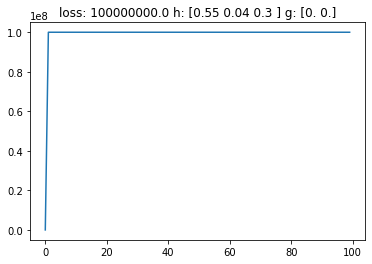

In [18]:
gc = result['g']
hc = result['h']
plt.plot(loss)
plt.title('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))
plt.show()

Text(0.5, 1.0, 'colored by voxel-cluster')

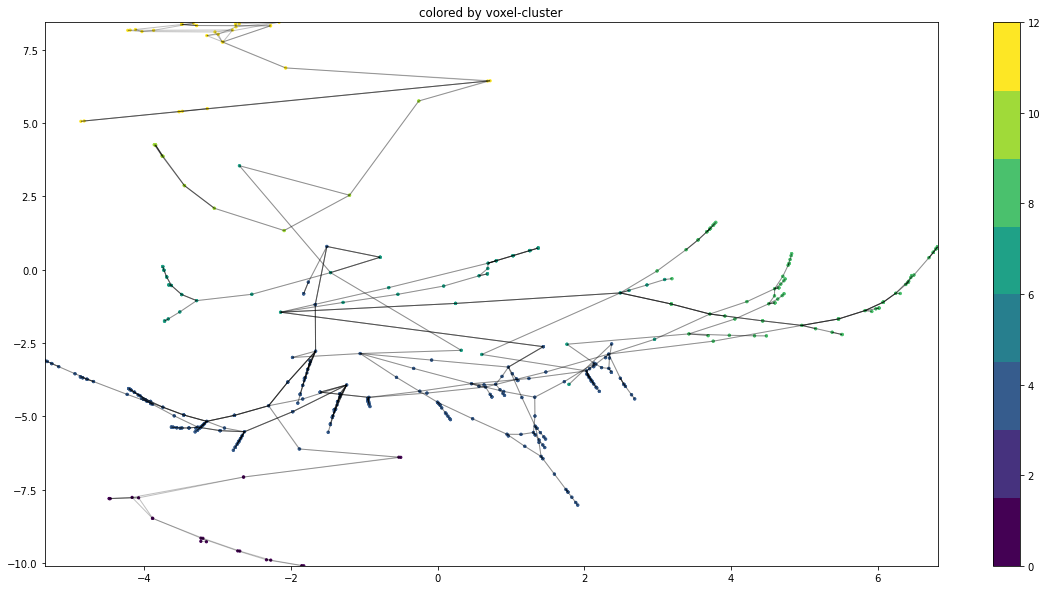

In [19]:
positions = result['x']

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_xlim(min(positions[:,0]), max(positions[:,0]))
ax.set_ylim(min(positions[:,1]), max(positions[:,1]))

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
ax.add_collection(lc)
#cmap = plt.cm.get_cmap('viridis', np.unique(voxel_id).shape[0])    # 11 discrete colors
scatter = ax.scatter(positions[:,0], positions[:,1], s=5, c=voxel_id, cmap=cmap)

#for c in np.where(cidx)[0]:
#    ax.annotate('({},{})'.format(str(np.round(X_k_n[c, 0],2)), str(np.round(X_k_n[c, 1],2))), (X_k_n[c, 0], X_k_n[c, 1]))

plt.colorbar(scatter, ax=ax)
plt.title('colored by voxel-cluster')
#plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

Text(0.5, 1.0, 'colored by voxel-cluster')

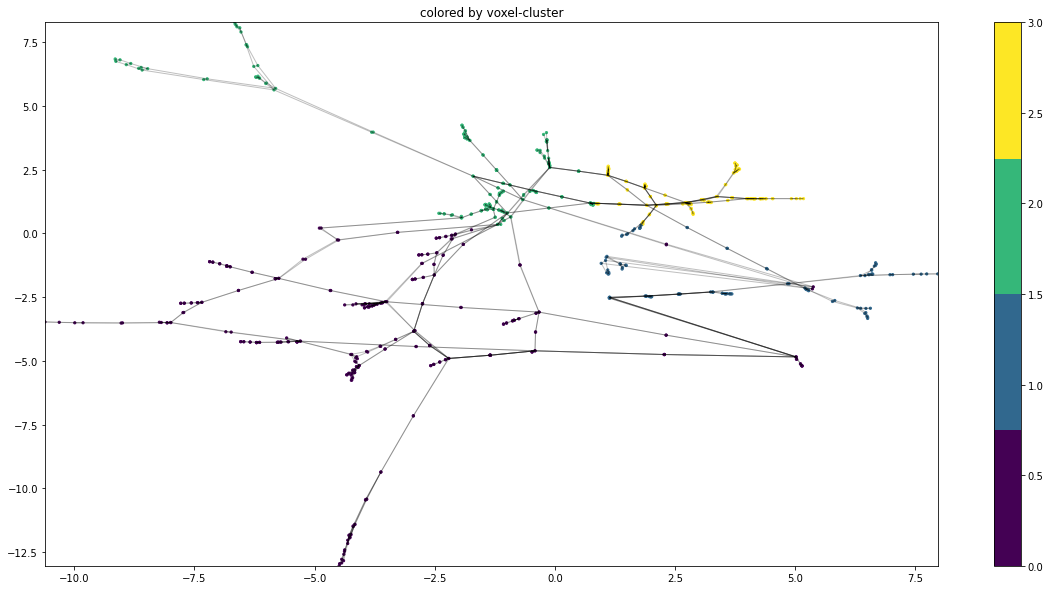

In [95]:
positions = result['x']

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_xlim(min(positions[:,0]), max(positions[:,0]))
ax.set_ylim(min(positions[:,1]), max(positions[:,1]))

lines = []
for i,j in zip(*graph.nonzero()):
    if i > j:
        lines.append([positions[i], positions[j]])

lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
ax.add_collection(lc)
#cmap = plt.cm.get_cmap('viridis', np.unique(voxel_id).shape[0])    # 11 discrete colors
scatter = ax.scatter(positions[:,0], positions[:,1], s=5, c=voxel_id, cmap=cmap)

#for c in np.where(cidx)[0]:
#    ax.annotate('({},{})'.format(str(np.round(X_k_n[c, 0],2)), str(np.round(X_k_n[c, 1],2))), (X_k_n[c, 0], X_k_n[c, 1]))

plt.colorbar(scatter, ax=ax)
plt.title('colored by voxel-cluster')
#plt.savefig(graph_name + '.svg', format='svg', dpi=1000)

In [22]:
!rm ./frames/*

ValueError: too many values to unpack (expected 2)

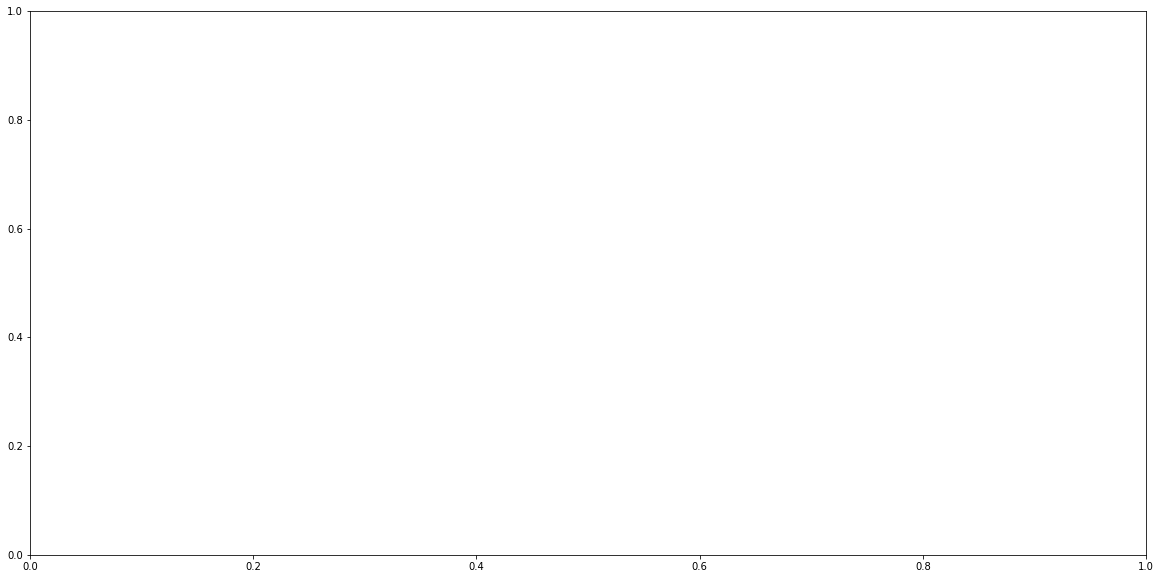

In [20]:
import time
from IPython import display
from IPython.display import clear_output

plt.figure(figsize=(20,10))
ax = plt.axes()
idx = np.linspace(0, len(param_hist)-1, num=100,dtype=int)

for l, result in enumerate(results):
    param_hist = result['sln_path']
    P_x, P_y = result['P']
    n0_x, n0_y = result['n']
    for k in idx:
        X_k = param_hist[k]

        X_k_n = np.zeros((n0_x.shape[0],2))
        X_k_n[:,0] = np.array(P_x.T@X_k[:,0]) + n0_x.T
        X_k_n[:,1] = np.array(P_y.T@X_k[:,1]) + n0_y.T
        positions = X_k_n

        ax.set_xlim(min(positions[:,0]), max(positions[:,0]))
        ax.set_ylim(min(positions[:,1]), max(positions[:,1]))

        lines = []
        for i,j in zip(*graph.nonzero()):
            if i > j:
                lines.append([positions[i], positions[j]])

        lc = mc.LineCollection(lines, linewidths=1, colors='k', alpha=.25)
        ax.clear()
        ax.add_collection(lc)
        ax.scatter(positions[:,0], positions[:,1], s=5, c=voxel_id, cmap=cmap)
        plt.savefig('./frames/{}_{}.png'.format(l, k))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        #time.sleep(0.1)

In [20]:
from IPython.display import Image
from PIL import Image
import glob, os

# filepaths
fp_in = "./frames/*.png"
fp_out = "./frames/animation.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in),key=os.path.getmtime)]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)